In [1]:
"""Imports & Setup"""

import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import (
    col, count, isnan, when, broadcast,
    to_timestamp, hour, avg, year, dayofweek, desc
)
from pyspark.sql.types import NumericType, StringType, TimestampType
from pyspark.sql.functions import from_unixtime

sys.path.append(os.path.abspath('..'))
from utils import get_spark_session, PATHS, plot_hourly_distribution_per_year

spark = get_spark_session("LargeST-Viz")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/09 16:52:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
"""Metadata Quality Check"""

import importlib
import utils

from utils import print_data_quality_report, PATHS

print(f"Loading metadata from: {PATHS['meta_csv']}")
meta_df = spark.read.csv(
    PATHS["meta_csv"],
    header=True,
    inferSchema=True
)

print("--- Metadata Quality Report ---")
print_data_quality_report(meta_df)

print("\n--- Descriptive Statistics (Numerical) ---")
meta_df.describe().show()

Loading metadata from: hdfs:///user/ubuntu/largeST/ca_meta.csv


--- Metadata Quality Report ---
Total Rows: 8600


+---------+-------------+-------------+
|column   |missing_count|missing_ratio|
+---------+-------------+-------------+
|ID       |0            |0.0          |
|Lat      |0            |0.0          |
|Lng      |0            |0.0          |
|District |0            |0.0          |
|County   |0            |0.0          |
|Fwy      |0            |0.0          |
|Lanes    |0            |0.0          |
|Type     |0            |0.0          |
|Direction|0            |0.0          |
|ID2      |0            |0.0          |
+---------+-------------+-------------+


--- Descriptive Statistics (Numerical) ---


26/01/09 16:52:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 8:>                                                          (0 + 1) / 1]

+-------+--------------------+------------------+-------------------+-----------------+-------+------+------------------+--------+---------+-----------------+
|summary|                  ID|               Lat|                Lng|         District| County|   Fwy|             Lanes|    Type|Direction|              ID2|
+-------+--------------------+------------------+-------------------+-----------------+-------+------+------------------+--------+---------+-----------------+
|  count|                8600|              8600|               8600|             8600|   8600|  8600|              8600|    8600|     8600|             8600|
|   mean|1.3203251513837209E7|35.574187225930324|-119.53173957651165|7.039302325581396|   NULL|  NULL|3.6276744186046512|    NULL|     NULL|           4299.5|
| stddev|  7.74370000771463E7| 2.012747137640088|   2.02229191472284|2.876953182310307|   NULL|  NULL|1.0690659034158123|    NULL|     NULL|2482.750490887073|
|    min|              308511|         32.5442

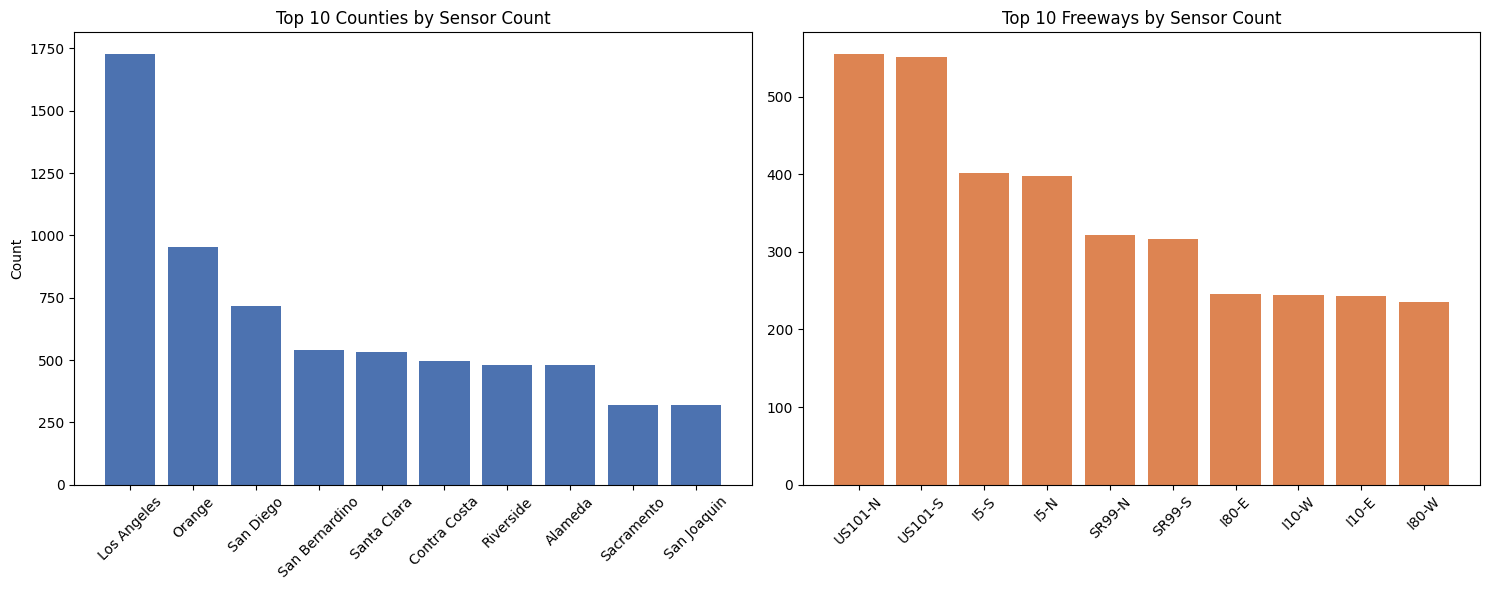

In [3]:
"""Sensor Distribution by Region (Bar Charts)"""

top_counties = meta_df.groupBy("County").count().orderBy(desc("count")).limit(10).toPandas()
top_freeways = meta_df.groupBy("Fwy").count().orderBy(desc("count")).limit(10).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(top_counties["County"], top_counties["count"], color="#4c72b0")
axes[0].set_title("Top 10 Counties by Sensor Count")
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylabel("Count")

axes[1].bar(top_freeways["Fwy"], top_freeways["count"], color="#dd8452")
axes[1].set_title("Top 10 Freeways by Sensor Count")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

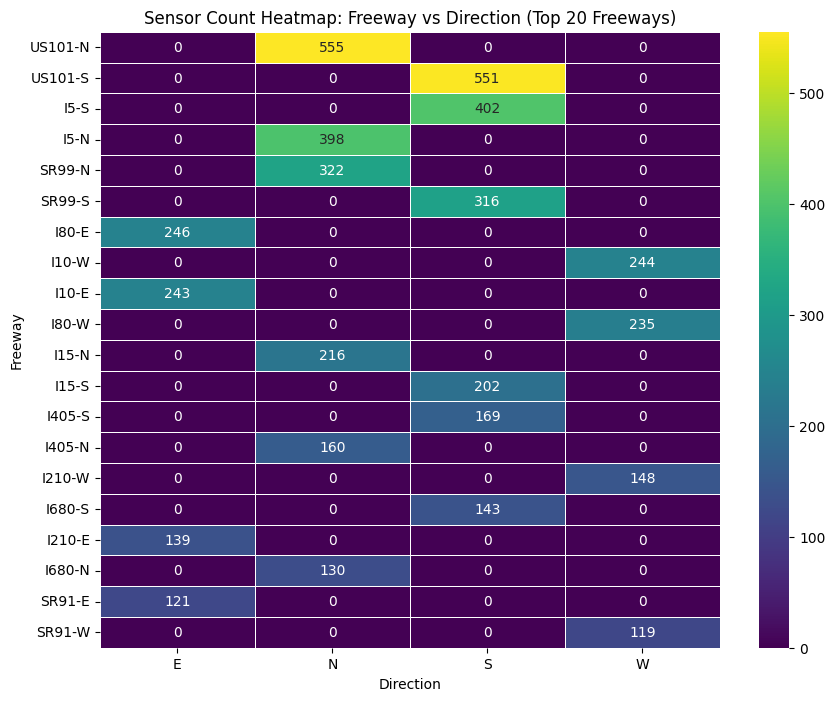

In [4]:
"""Freeway vs Direction Heatmap"""

fw_dir = (
    meta_df.groupBy("Fwy", "Direction")
    .count()
    .orderBy(desc("count"))
)

fw_dir_pd = fw_dir.toPandas().pivot(index="Fwy", columns="Direction", values="count").fillna(0)

top_20_fwy = fw_dir_pd.sum(axis=1).sort_values(ascending=False).head(20).index
fw_dir_pd_subset = fw_dir_pd.loc[top_20_fwy]

plt.figure(figsize=(10, 8))
sns.heatmap(fw_dir_pd_subset, annot=True, fmt=".0f", cmap="viridis", linewidths=.5)
plt.title("Sensor Count Heatmap: Freeway vs Direction (Top 20 Freeways)")
plt.ylabel("Freeway")
plt.xlabel("Direction")
plt.show()

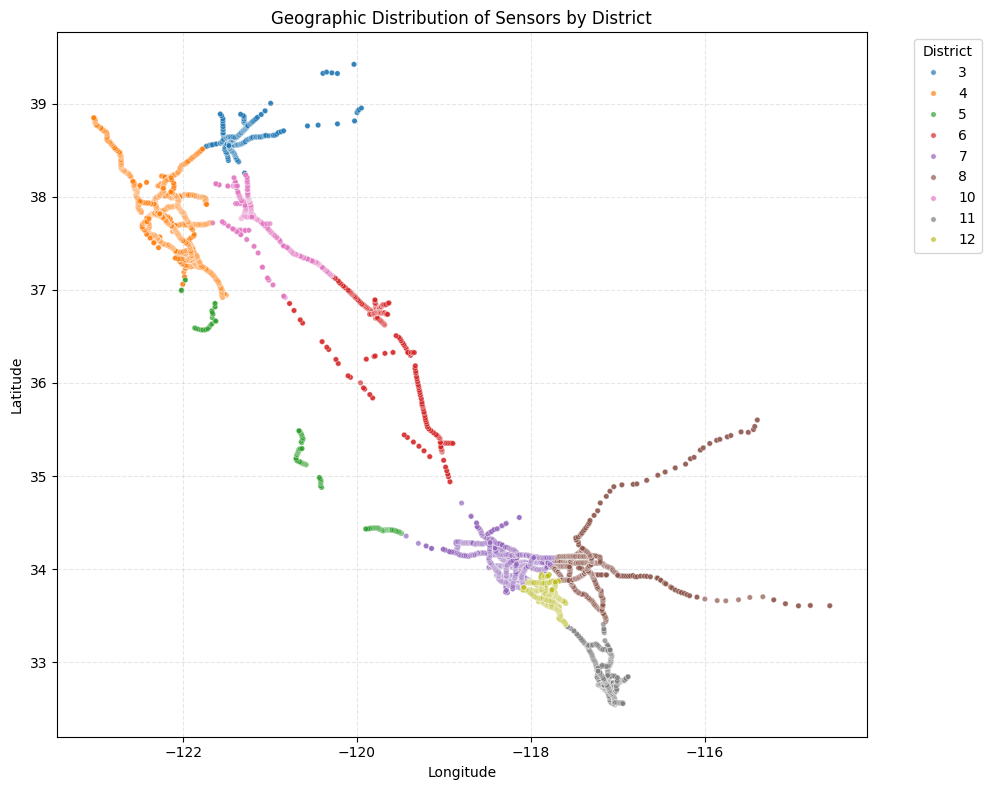

In [5]:
"""Sensor Locations Map"""

pdf_loc = meta_df.select("Lng", "Lat", "District").toPandas()

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pdf_loc, 
    x="Lng", 
    y="Lat", 
    hue="District", 
    palette="tab10", 
    s=15, 
    alpha=0.7,
    legend="full"
)

plt.title("Geographic Distribution of Sensors by District")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="District")
plt.tight_layout()
plt.show()

In [6]:
"""Load Raw Data & Metadata"""

traffic_df = spark.read.parquet(PATHS["raw_parquet"])

meta_df = spark.read.csv(
    PATHS["meta_csv"],
    header=True,
    inferSchema=True
)

print("Raw Traffic Schema:")
traffic_df.printSchema()
print("Metadata Schema:")
meta_df.printSchema()

Raw Traffic Schema:
root
 |-- timestamp: long (nullable = true)
 |-- sensor_id: string (nullable = true)
 |-- value: double (nullable = true)
 |-- year: integer (nullable = true)

Metadata Schema:
root
 |-- ID: integer (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lng: double (nullable = true)
 |-- District: integer (nullable = true)
 |-- County: string (nullable = true)
 |-- Fwy: string (nullable = true)
 |-- Lanes: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Direction: string (nullable = true)
 |-- ID2: integer (nullable = true)



In [3]:
"""Data Cleaning & Enrichment (ETL)"""

traffic_df = traffic_df.withColumn("sensor_id_int", col("sensor_id").cast("int"))

full_df = traffic_df.join(
    meta_df,
    traffic_df.sensor_id_int == meta_df.ID,
    how="left"
).drop("sensor_id_int")

full_df = full_df.withColumn(
    "timestamp_ts",
    from_unixtime(col("timestamp") / 1_000_000_000).cast("timestamp")
).drop("timestamp").withColumnRenamed("timestamp_ts", "timestamp")

clean_df = full_df.dropna()

print(f"Row count after cleaning: {clean_df.count()}")
clean_df.show(5)

Row count after cleaning: 4406085187
+---------+-----+----+-------+---------+-----------+--------+---------+------+-----+--------+---------+----+-------------------+
|sensor_id|value|year|     ID|      Lat|        Lng|District|   County|   Fwy|Lanes|    Type|Direction| ID2|          timestamp|
+---------+-----+----+-------+---------+-----------+--------+---------+------+-----+--------+---------+----+-------------------+
|  1118894|167.0|2020|1118894|32.729729|-117.107696|      11|San Diego|I805-S|    5|Mainline|        S|7600|2020-01-31 00:00:00|
|  1119383| 19.0|2020|1119383|32.729896|-117.107497|      11|San Diego|I805-S|    5|Mainline|        S|7601|2020-01-31 00:00:00|
|  1123210|114.0|2020|1123210|32.740965|-117.116526|      11|San Diego|I805-S|    4|Mainline|        S|7602|2020-01-31 00:00:00|
|  1111543|123.0|2020|1111543|32.748425| -117.12253|      11|San Diego|I805-S|    5|Mainline|        S|7603|2020-01-31 00:00:00|
|  1111542|106.0|2020|1111542|32.756165| -117.12539|      11

In [4]:
"""Save Enriched Data"""

print(f"Saving cleaned data to: {PATHS['clean_enriched']}")

clean_df.write.mode("overwrite").parquet(PATHS["clean_enriched"])

print("Data saved successfully.")

Saving cleaned data to: hdfs:///user/ubuntu/largest_parquet_clean_enriched/clean_enriched


Data saved successfully.


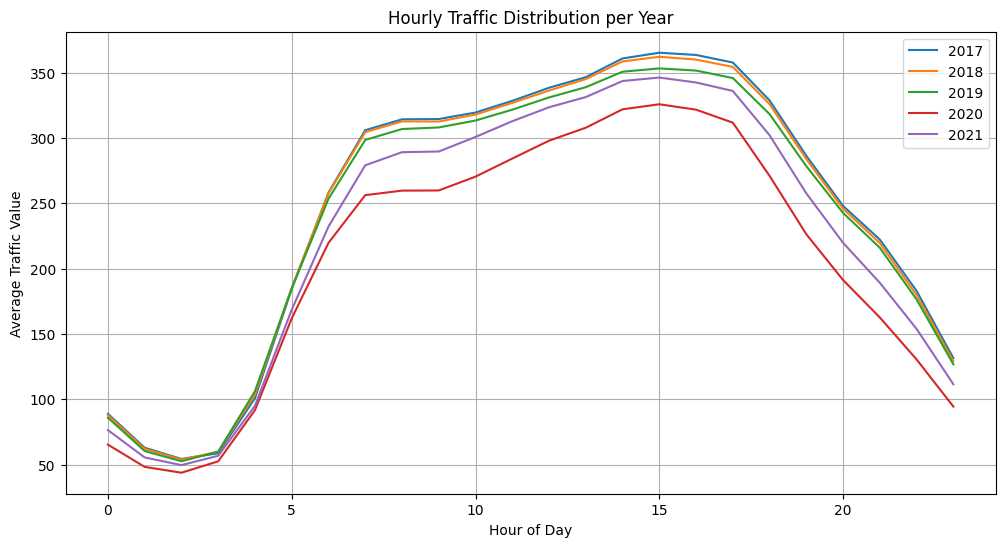

In [5]:
"""Analysis 1 - Hourly Traffic Distribution"""

hourly_year_df = (
    clean_df
    .withColumn("hour", hour(col("timestamp")))
    .groupBy("year", "hour")
    .agg(avg("value").alias("avg_value"))
)
hourly_year_df.cache()

plot_hourly_distribution_per_year(hourly_year_df)

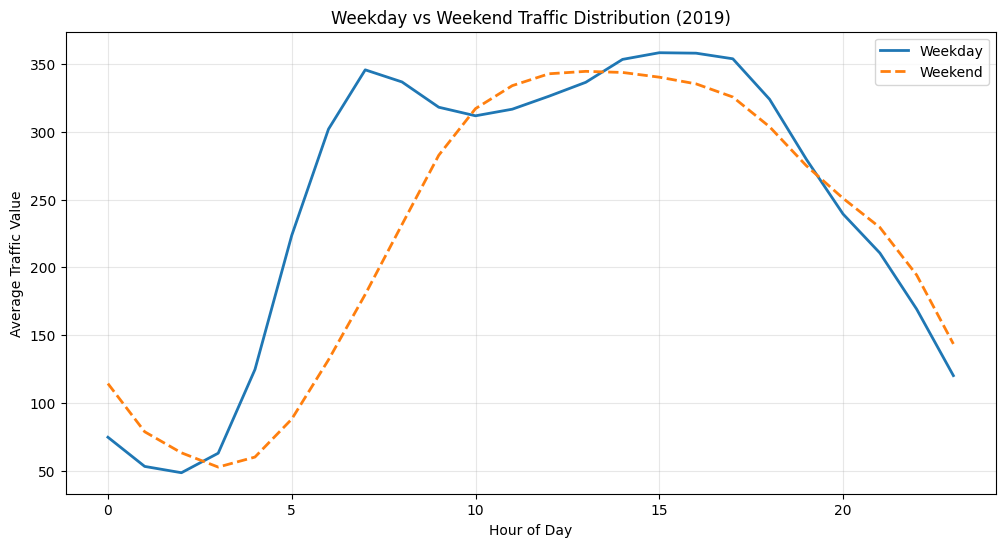

In [6]:
"""Analysis 2 - Weekday vs Weekend Patterns"""

weekday_weekend_df = (
    clean_df
    .withColumn("hour", hour(col("timestamp")))
    .withColumn("is_weekend", dayofweek(col("timestamp")).isin([1, 7])) # 1=Sun, 7=Sat
    .groupBy("year", "is_weekend", "hour")
    .agg(avg("value").alias("avg_value"))
)
weekday_weekend_df.cache()

def plot_weekday_weekend(cached_weekday_df, selected_year):
    pd_df = (
        cached_weekday_df
        .filter(col("year") == selected_year)
        .orderBy("hour")
        .toPandas()
    )

    weekday_pd = pd_df[pd_df["is_weekend"] == False]
    weekend_pd = pd_df[pd_df["is_weekend"] == True]

    plt.figure(figsize=(12, 6))
    plt.plot(weekday_pd["hour"], weekday_pd["avg_value"], label="Weekday", linewidth=2)
    plt.plot(weekend_pd["hour"], weekend_pd["avg_value"], label="Weekend", linewidth=2, linestyle="--")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Traffic Value")
    plt.title(f"Weekday vs Weekend Traffic Distribution ({selected_year})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_weekday_weekend(weekday_weekend_df, selected_year=2019)

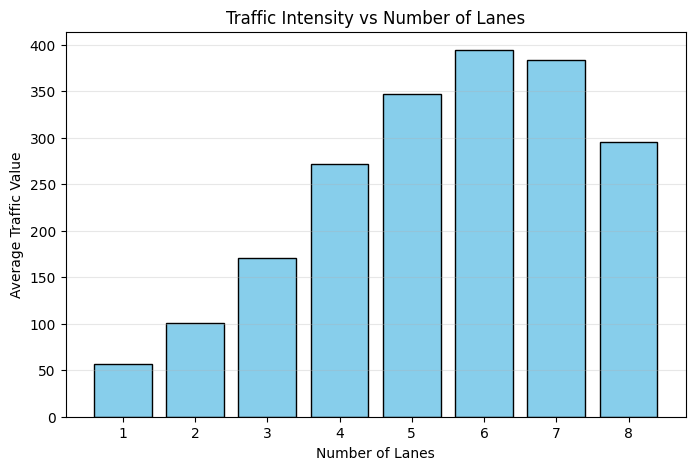

In [7]:
"""Analysis 3 - Traffic by Number of Lanes"""

traffic_by_lanes_df = (
    clean_df
    .groupBy("sensor_id", "Lanes")
    .agg(avg("value").alias("avg_traffic"))
    .groupBy("Lanes")
    .agg(avg("avg_traffic").alias("mean_traffic"))
    .orderBy("Lanes")
)

lanes_pd = traffic_by_lanes_df.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(lanes_pd["Lanes"], lanes_pd["mean_traffic"], color='skyblue', edgecolor='black')
plt.xlabel("Number of Lanes")
plt.ylabel("Average Traffic Value")
plt.title("Traffic Intensity vs Number of Lanes")
plt.grid(axis='y', alpha=0.3)
plt.show()

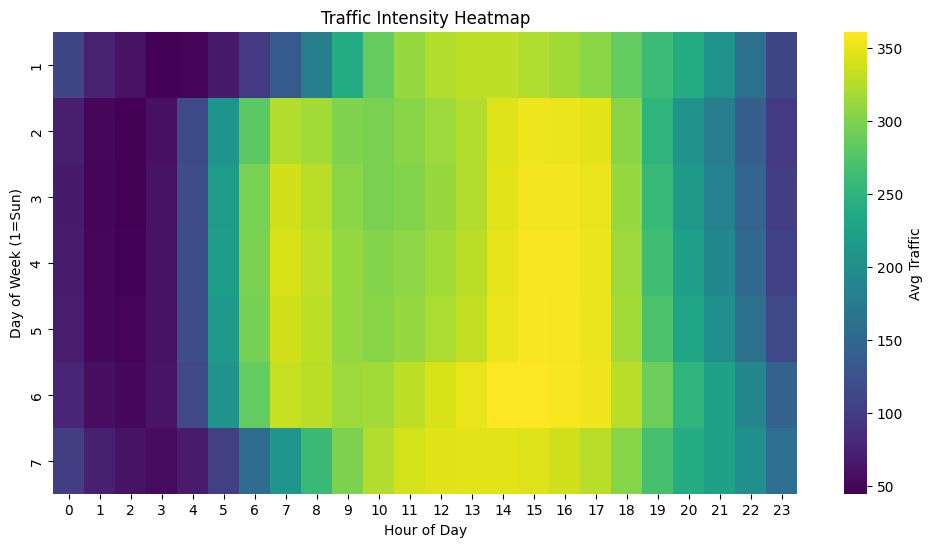

In [8]:
"""Analysis 4 - Day of Week x Hour Heatmap"""

hour_weekday_df = (
    clean_df
    .withColumn("hour", hour("timestamp"))
    .withColumn("weekday", dayofweek("timestamp"))
    .groupBy("weekday", "hour")
    .agg(avg("value").alias("avg_value"))
)

heatmap_pd = hour_weekday_df.toPandas()
heatmap_matrix = heatmap_pd.pivot(
    index="weekday",
    columns="hour",
    values="avg_value"
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_matrix, cmap="viridis", cbar_kws={'label': 'Avg Traffic'})
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week (1=Sun)")
plt.title("Traffic Intensity Heatmap")
plt.show()

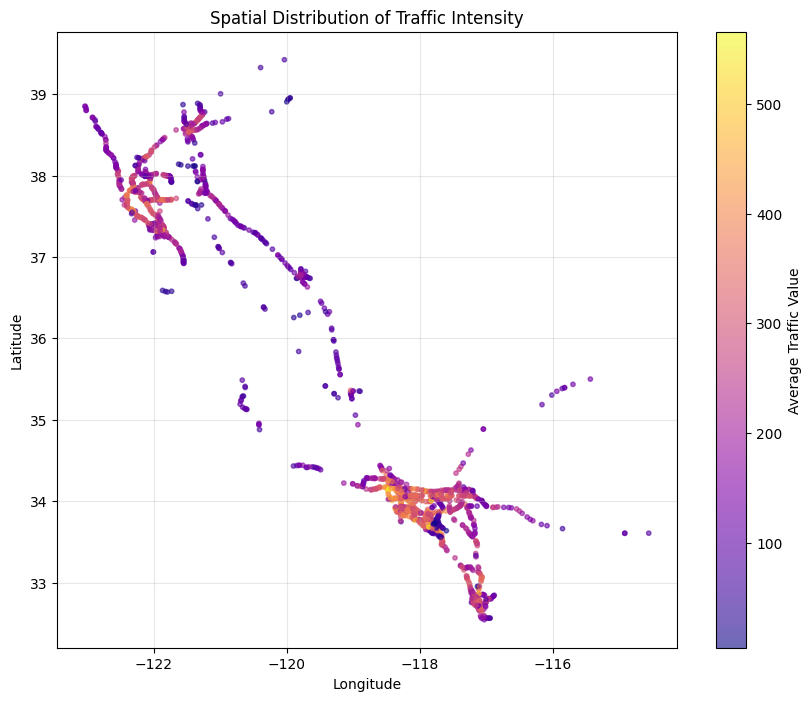

In [9]:
"""Analysis 5 - Spatial Distribution"""

spatial_df = (
    clean_df
    .groupBy("sensor_id", "Lat", "Lng")
    .agg(avg("value").alias("avg_traffic"))
)

spatial_pd = spatial_df.sample(fraction=0.2, seed=42).toPandas()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    spatial_pd["Lng"],
    spatial_pd["Lat"],
    c=spatial_pd["avg_traffic"],
    cmap="plasma",
    s=10,
    alpha=0.6
)
plt.colorbar(scatter, label="Average Traffic Value")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Traffic Intensity")
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
"""Cleaning"""

spark.stop()